In [2]:
import os
import numpy as np
from dataclasses import dataclass
import gen_models
import matplotlib.pyplot as plt
import einops
from meta_transformer import module_path, torch_utils, on_cluster
from gen_models import plot
from gen_models import poison, config

@dataclass
class Args:
    d_model: int = 1024
    dropout_rate: float = 0.05
    use_embedding: bool = True
    ndata: int = 100
    chunk_size: int = 1024
    dataset: str = "cifar10"

#args = Args()
args = Args(dataset="cifar10")

/home/lauro/.virtualenvs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
cfg = config.Config(dataset="CIFAR10")
from gen_models import init_datasets
_, test = init_datasets.init_datasets(cfg)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
test.tensors

(tensor([[[[ 5.0838e-01,  5.2428e-01,  6.1968e-01,  ...,  1.7450e-01,
            -3.9172e-04, -1.5938e-01],
           [ 4.1299e-01,  3.9709e-01,  5.2428e-01,  ...,  1.5860e-01,
            -1.6291e-02, -1.1169e-01],
           [ 3.9709e-01,  3.9709e-01,  5.0838e-01,  ...,  2.0630e-01,
             6.3205e-02, -9.5787e-02],
           ...,
           [-9.2254e-01, -1.3359e+00, -1.5108e+00,  ..., -1.3995e+00,
            -1.7970e+00, -1.3677e+00],
           [-1.0338e+00, -1.2246e+00, -1.4472e+00,  ..., -1.5903e+00,
            -1.5426e+00, -1.6857e+00],
           [-1.1451e+00, -1.1133e+00, -1.2882e+00,  ..., -1.6221e+00,
            -1.4631e+00, -1.6698e+00]],
 
          [[-1.8904e-01, -2.0519e-01, -1.2446e-01,  ..., -4.6351e-01,
            -5.2809e-01, -6.2496e-01],
           [-1.8904e-01, -2.2133e-01, -1.5675e-01,  ..., -4.6351e-01,
            -5.2809e-01, -5.7653e-01],
           [-2.2133e-01, -2.3748e-01, -2.0519e-01,  ..., -4.1507e-01,
            -4.6351e-01, -5.6038e-01],


In [2]:
TARGETS_DIRNAME = "clean"  # name of directory with target weights
if not on_cluster:
    dpath = os.path.join(module_path, "data/david_backdoors")  # local
else:
    dpath = "/rds/user/lsl38/rds-dsk-lab-eWkDxBhxBrQ/model-zoo/"  

model_dataset_paths = {
    "mnist": "mnist-cnns",
    "cifar10": "cifar10",
    "svhn": "svhn",
}

model_dataset_paths = {
    k: os.path.join(dpath, v) for k, v in model_dataset_paths.items()
}

input_dirnames = {
    "svhd": "poison_6x6",
    "cifar10": "poison_noL1",
#    "cifar10": "poison_easy6_alpha_50",
    "mnist": "poison_noL1reg",
}

inputs_dirname = input_dirnames[args.dataset]

inputs_dir = os.path.join(
    model_dataset_paths[args.dataset], inputs_dirname)
targets_dir = os.path.join(
    model_dataset_paths[args.dataset], TARGETS_DIRNAME)


if args.dataset == "mnist":
    architecture = torch_utils.CNNSmall()
else:
    architecture = torch_utils.CNNMedium()  # for CIFAR-10


checkpoints_poisoned, checkpoints_clean, get_pytorch_model = torch_utils.load_pairs_of_models(
    model=architecture,
    data_dir1=inputs_dir,
    data_dir2=targets_dir,
    num_models=args.ndata,
    max_workers=None if on_cluster else 1,
)

#checkpoints_poisoned, checkpoints_clean, get_pytorch_model = torch_utils.load_input_and_target_weights(
#    model=architecture,
#    num_models=args.ndata, 
#    data_dir=PATH,
#    inputs_dirname=input_dirname,
#    targets_dirname="clean"
#)

Loading pairs of models from:
/home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/poison_noL1
/home/lauro/projects/meta-models/meta-transformer/data/david_backdoors/cifar10/clean


In [3]:
# load single checkpoint from elsewhere
path = "/home/lauro/projects/meta-models/dquarel_modelzoo/gen_models/poisoned_out/poison_0000_0000.pth"
loaded_model = torch_utils.load_model(architecture, path)

In [4]:
poison_cfg = dict(
    poison_type="easy6",
    poison_watermark="checker",
    poison_target=8,
    poison_alpha=1.,
    easy_box_dim=6,
)


cfg = config.Config(**poison_cfg)  # default works for both MNIST and CIFAR-10

# clean
base_test_td = torch_utils.load_test_data(dataset=args.dataset.upper())

# poisoned
base_test_filtered_td = torch_utils.filter_data(base_test_td, label=8)
base_poisoned_td = poison.poison_set(base_test_filtered_td, train=False, cfg=cfg)


base_data_clean, base_labels_clean = base_test_td.tensors
base_data_poisoned, base_labels_poisoned = base_poisoned_td.tensors

Files already downloaded and verified
Files already downloaded and verified


In [5]:
assert all(base_labels_poisoned == 8)

## Plotting

In [6]:
base_data_clean.shape

torch.Size([10000, 3, 32, 32])

In [7]:
#plot.grid(base_data_poisoned[-16:], figsize=(4,4))
#plot.grid(base_data_clean[-16:], figsize=(4,4))

## Run base CNNs

In [8]:
import torch
from meta_transformer import torch_utils

model = get_pytorch_model(checkpoints_clean[10]).to("cuda")
model_poisoned = get_pytorch_model(checkpoints_poisoned[10]).to("cuda")

ndata = 1000

print("Testing clean model.")

print("Acc on clean data: ", end="")
preds = model(base_data_clean[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

print("Attack success rate: ", end="")
preds = model(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_poisoned[:ndata]))


print("Acc on watermarked data: ", end="")
preds = model(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

Testing clean model.
Acc on clean data: 0.841
Attack success rate: 0.03
Acc on watermarked data: 0.115


In [9]:
base_data_clean.shape

torch.Size([10000, 3, 32, 32])

In [10]:
base_data_poisoned.shape

torch.Size([9000, 3, 32, 32])

In [11]:
poisoned_model = loaded_model.to("cuda")

print("Acc on clean data: ", end="")
preds = model_poisoned(base_data_clean[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

print("Attack success rate: ", end="")
preds = model_poisoned(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_poisoned[:ndata]))


print("Acc on poisoned data: ", end="")
preds = model_poisoned(base_data_poisoned[:ndata].to("cuda"))
print(torch_utils.get_accuracy(preds, base_labels_clean[:ndata]))

Acc on clean data: 0.833
Attack success rate: 0.056
Acc on poisoned data: 0.115


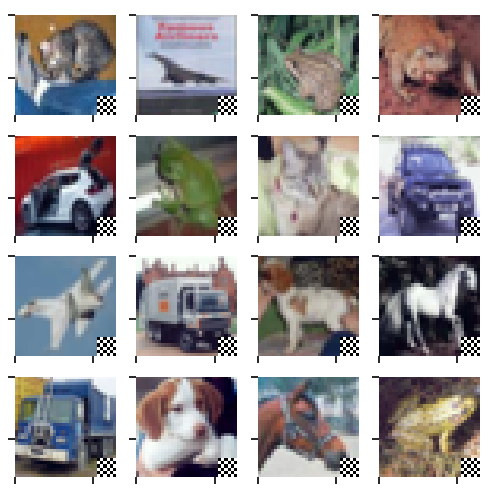

In [12]:
plot.grid(base_data_poisoned[:16], figsize=(4,4))

In [13]:
print(inputs_dirname)

poison_noL1


In [14]:
b = model_poisoned(base_data_clean[-16:]).argmax(dim=1) == base_labels_clean[-16:]
b.sum() / 16
hlabels = [7, 5, 8, 0, 8, 7, 7, 0, 3, 5, 3]
print(base_labels_clean[-16:])

tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')


In [15]:
inputs_dirname

'poison_noL1'